In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

from tensorflow.python.data import Dataset

# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
tf.executing_eagerly()
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('INFO')

In [3]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [0]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True,count=None):
  ds = tf.data.Dataset.from_tensor_slices((dict(features),targets))
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)
  ds = ds.batch(batch_size).repeat(count)
  return ds

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  training_input_fn = lambda:input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: input_fn(my_feature_data, targets, count=1, shuffle=False)
 
  my_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm =5.0)
  model = tf.estimator.LinearRegressor(feature_columns = feature_columns,
                                       optimizer = my_optimizer) 

  # Set up to plot the state of our model's line each period. 
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  
  print("Training model...")
  print("RMSE (on training data):")
  
  history = model.train(input_fn=training_input_fn,
                        steps=steps)
  predictions = model.predict(input_fn=prediction_input_fn)
  predictions = np.array([item['predictions'][0] for item in predictions])
  
  root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
    
  x_0 = sample["total_rooms"].min()
  x_1 = sample["total_rooms"].max()
  #weight = model.get_variable_names()
  weight = model.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
  bias = model.get_variable_value('linear/linear_model/bias_weights')

  y_0 = weight*x_0 + bias
  y_1 = weight*x_1 + bias

  plt.plot([x_0, x_1], [y_0, y_1], color='g')
  plt.xlabel("total_rooms")
  plt.ylabel("median_house_values")
  plt.show()
  print("Model training finished.")

  data = pd.DataFrame()
  data["predictions"] = pd.Series(predictions)
  data["targets"] = pd.Series(targets)
  print(data.describe())

  min_house_value = california_housing_dataframe["median_house_value"].min()
  max_house_value = california_housing_dataframe["median_house_value"].max()
  min_max_difference = max_house_value - min_house_value

  print("Min. Median House Value: %0.3f" % min_house_value)
  print("Max. Median House Value: %0.3f" % max_house_value)
  print("Difference between Min. and Max.: %0.3f" % min_max_difference)
  print("Final RMSE (on training data): %0.3f" % root_mean_squared_error)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbvwxqefs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f72d57c6080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Instructions 

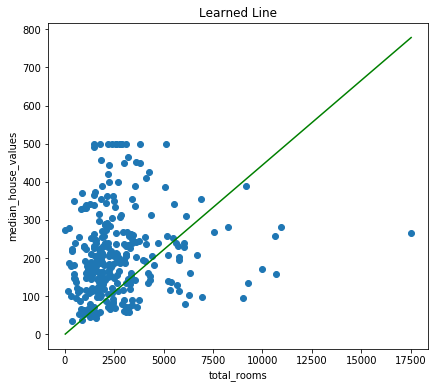

Model training finished.
       predictions  targets
count      17000.0  17000.0
mean         117.4    207.3
std           96.8    116.0
min            0.1     15.0
25%           65.0    119.4
50%           94.5    180.4
75%          140.0    265.0
max         1684.5    500.0
Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Final RMSE (on training data): 167.198


In [7]:
train_model(learning_rate=0.00002,
            steps=500,
            batch_size=5)